# Problem Set 2

In [1]:
import numpy as np
import scipy as sp
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve
from scipy.io import loadmat
import matplotlib.tri as tri
import matplotlib.pyplot as plt

## Load and plot the grids

In [2]:
grids = loadmat('FE_grid.mat', simplify_cells=True)
print(grids.keys())
coarse_grid = grids['FE_grid']['coarse']
# show the keys in the grid
print(coarse_grid.keys())
print("number of nodes:", coarse_grid['nodes'])
print("number of elements:", coarse_grid['elements'])
x = coarse_grid['coor'][:, 0]
y = coarse_grid['coor'][:, 1]
z = np.sin(np.pi*x)*np.cos(np.pi*y)
# be careful  the indices must start at 0, in mat files they start at one, so substract 1
triangles = np.concatenate(coarse_grid['theta'][0:5]-1)
T = tri.Triangulation(x, y, triangles)

dict_keys(['__header__', '__version__', '__globals__', 'FE_grid'])
dict_keys(['nodes', 'coor', 'elements', 'theta'])
number of nodes: 1333
number of elements: 2095


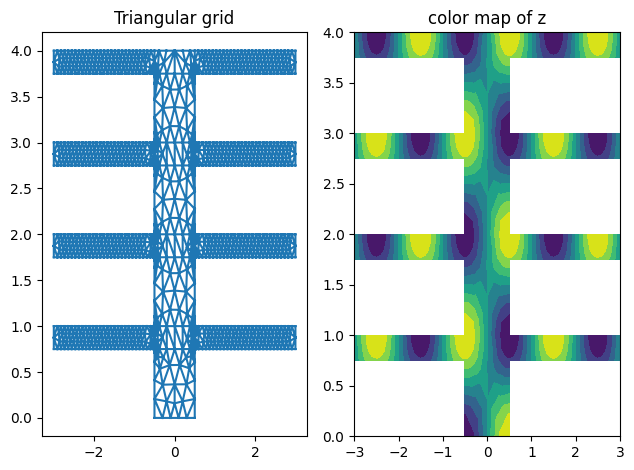

In [3]:
def plot(mesh, u):
    fig, axs = plt.subplots(nrows=1, ncols=2)
    axs = axs.flatten()

    # Plot the triangulation.
    axs[0].triplot(mesh)
    axs[0].set_title('Triangular grid')

    # Plot the color map.
    axs[1].tricontourf(mesh, u)
    axs[1].set_title('color map of z')
    fig.tight_layout()
    plt.show()


plot(T, z)

# Load the matrices

In [4]:
M = loadmat('FE_matrix.mat', simplify_cells=True)
Aq_coarse = M['FE_matrix']['coarse']['Ahq']
Fh_coarse = M['FE_matrix']['coarse']['Fh']

## Solve the finite element problem

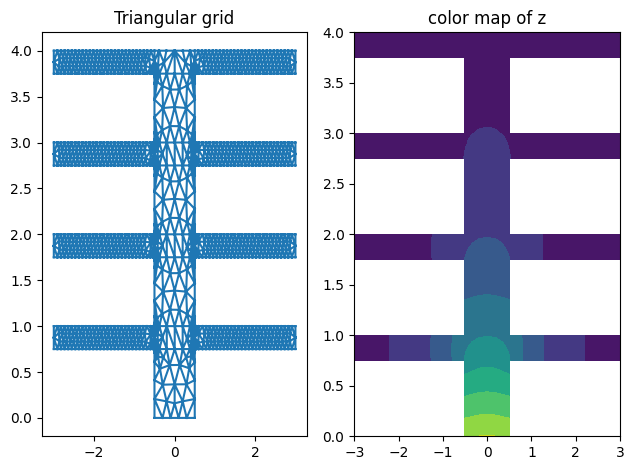

In [5]:
def assembleA(µ, Aq):
    A = csc_matrix(µ[0]*Aq[0])
    for k in range(1, 6):
        A += µ[k]*Aq[k]
    return A


k_i = 1
Bi = 0.1
µ = np.array([k_i, k_i, k_i, k_i, 1, Bi])
A = assembleA(µ, Aq_coarse)
u = spsolve(A, Fh_coarse)
plot(T, u)

In [6]:
medium_grid = grids['FE_grid']['medium']
print("Medium - number of nodes:", medium_grid['nodes'])
print("Medium - number of elements:", medium_grid['elements'])

Medium - number of nodes: 4760
Medium - number of elements: 8380


In [7]:
fine_grid = grids['FE_grid']['fine']
print("Fine - number of nodes:", fine_grid['nodes'])
print("Fine - number of elements:", fine_grid['elements'])

Fine - number of nodes: 17899
Fine - number of elements: 33520


# Techniques de réduction de l'ordre des modèles

## Partie 1 - Approximation à base réduite

a) ***Montrez que le nombre d'opérations pour l'étape en ligne de votre code est indépendant de $\mathcal{N}$. En particulier, montrez que le nombre d'opérations (nombre d'opérations à virgule flottante) pour l'étape en ligne, pour chaque nouveau $\mu$ d'intérêt, peut être exprimé comme suit $$c_1 N^{\gamma_1} + c_2 N^{\gamma_2} + c_3 N^{\gamma_3}$$ pour $c_1$, $c_2$, $c_3$, $\gamma_1$, $\gamma_2$, et $\gamma_3$ indépendants de $\mathcal{N}$. Donner les valeurs des constantes $c_1$, $c_2$, $c_3$, $\gamma_1$, $\gamma_2$, et $\gamma_3$.***

---

Dénombrons le nombre d'opérations en virgule flottante (multiplications et additions) nécessaire à chaque étape :

  * ***Formation de $A_N(\mu)$*** :
    - Comme $A_N(\mu)=\sum_{q=1}^Q \Theta^q(\mu)A_N^q$, cela nous donne $QN^2$ multiplications, et $(Q-1)N^2$ additions, soit un total de $(2Q-1)N^2$ flops.
  * ***Résolution du système linéaire $N\times N$,  $A_N(\mu)u_N(\mu)=F_N$*** :
    - Nécessite au plus $N^3$ flops.
    - Dans le cas de la décomposition $LU$ (où $L$ a des 1 le long de sa diagonale), le coût de la décomposition est $\frac{2N^3}{3} -\frac{N^2}{2}-\frac{N}{6}$ flops, le coût de la descente est $N(N+1)$, et le coût de la remontée est $N(N+1)+N$.
  * ***Évaluation de la sortie $T_{rootN}(\mu)=L_N^Tu_N(\mu)$*** :
    - Nécessite $2N-1$ flops comme produit scalaire.

Au final, le nombre d'opérations pour l'étape en ligne est indépendant de $\mathcal{N}$, il vaut
$$(2Q-1)N^2+ \frac{2N^3}{3}-\frac{N^2}{2}-\frac{N}{6} +2N(N+1)+N + 2N-1$$
ce qui fait
$$\frac{2}{3}N^3 + (2Q+\frac{1}{2})N^2 + \frac{29}{6}N - 1$$
soit environ
$$c_1N^{\gamma_1}+c_2N^{\gamma_2}+c_3N^{\gamma_3}$$
avec :
$$\begin{align*}
	\begin{cases}
		c_1 = \frac{29}{6}, &\quad \gamma_1=1 \\
		c_2 = 2Q+\frac{1}{2},&\quad \gamma_2 = 2 \qquad (Q=6)\\
		c_3 = \frac{2}{3},&\quad \gamma_3 = 3
	\end{cases}
\end{align*}$$

**b**) *Nous considérons d'abord un problème à un paramètre ($P = 1$). A cet effet, nous maintenons le nombre de Biot fixé à $Bi = 0.1$ et supposons que les conductivités de toutes les ailettes sont équivalentes, c'est-à-dire $k1 = k2 = k3 = k4$, mais sont  autorisées à varier entre $0.1$ et $10$ nous avons donc $\mu \in D = [0.1, 10]$. L'ensemble d'échantillons $S_N$ pour $N_{max} = 8$ est donné dans le fichier de données `RB_sample.sample1`.*

In [8]:
def loadFEMat(fineness):
    M = loadmat('FE_matrix.mat', simplify_cells=True)
    Ahq = M['FE_matrix'][fineness]['Ahq']
    Fh = M['FE_matrix'][fineness]['Fh']
    return Ahq, Fh


def loadSample(sample):
    return loadmat('RB_sample.mat', simplify_cells=True)["RB_sample"][sample]

In [9]:
# Fabrique la matrice Z
def buildZ(sample, Ahq, Fh, N, case):
    Ncal = Ahq[0].shape[0]
    Z = np.zeros((Ncal, N))

    if case == 3:
        carSample = list(zip(sample[0], sample[1]))
        assert (N <= len(carSample))
    else:
        assert (N <= len(sample))

    for j in range(N):
        if case == 1:  # Question b)
            ki = sample[j]
            µ = np.array([ki, ki, ki, ki, 1, 0.1])
        if case == 2:  # Question c)
            Bi = sample[j]
            µ = np.array([0.4, 0.6, 0.8, 1.2, 1, Bi])
        if case == 3:  # Question d)
            ki, Bi = carSample[j]
            µ = np.array([ki, ki, ki, ki, 1, Bi])
        u = spsolve(assembleA(µ, Ahq), Fh)
        Z[:, j] = u

    return Z

In [10]:
# Paramètres pour la question b)
Ahq, Fh = loadFEMat("coarse")
muBar = np.array([1, 1, 1, 1, 1, 0.1])
AhqBar = assembleA(muBar, Ahq)
sample1 = loadSample("sample1")

In [11]:
def inner(u, v):  # Produit interne de X
    return u @ AhqBar @ v


def norm(u):  # Norme de X
    return np.sqrt(inner(u, u))


def proj(v, u):  # Projection de v sur u en utilisant le produit interne AhqBar
    return inner(u, v) * u / inner(u, u)


def orthonormalize(Z):  # Orthonormalisation
    Z_ = np.zeros_like(Z)
    Z_[:, 0] = Z[:, 0] / norm(Z[:, 0])

    N = Z.shape[1]
    for j in range(1, N):
        xj = Z[:, j]
        for k in range(0, j):
            xj -= proj(Z[:, j], Z_[:, k])
        Z_[:, j] = xj / norm(xj)
    return Z_


def buildOff(Z, Ahq, Fh):  # Construction hors ligne des composants nécessaires
    Anq = []
    for q in range(0, 6):
        Anq.append(csc_matrix(Z.T @ Ahq[q] @ Z))

    Fn = Z.T @ Fh
    Ln = Z.T @ Fh

    return Anq, Fn, Ln

## 1. Génération la matrice de base réduite Z et toutes les quantités de base réduite nécessaires.

Pour $N=8$, $\mu=1$ et $\mu = 10$, comparons le conditionnement de $A_N(\mu)$, noté $\mathrm{Cond}(A_N(\mu))$, lorsque la matrice $Z$ est ou n'est pas orthonormalisée à l'aide de l'algorithme de Gram-Schmidt (GS). $\gamma$ et $\alpha$ sont respectivement les constantes de continuité (constante de Lipschitz) et de coercivité pour $A_{\cal{N}}$.
* $\mu=1$:
	- **Sans GS** : $\text{Cond}(A_N(\mu)) \simeq 33575189919.51$
	- **Avec GS** : $\text{Cond}(A_N(\mu)) \simeq 1.000000000093516$
	- **Borne supérieure** : $\frac{\gamma(\mu)}{\alpha(\mu)} \simeq 1.0000000000000187$
* $\mu=10$:
	- **Sans GS**: $\text{Cond}(A_N(\mu)) \simeq 23018985183.55$
	- **Avec GS**: $\text{Cond}(A_N(\mu)) \simeq 9.928605814$
	- **Borne supérieure**: $\frac{\gamma(\mu)}{\alpha(\mu)} \simeq 10.000000000001219$

In [12]:
Z = buildZ(sample1, Ahq, Fh, 8, 1)
Z_ = orthonormalize(Z)


def assemble_cond(Z, µ, Ahq, Fh):  # Calcule le conditionnement
    Anq, _, _ = buildOff(Z, Ahq, Fh)
    An = assembleA(µ, Anq)
    return np.linalg.cond(An.todense())


def assemble_const(µ, Ahq, AhqBar): # Calcule les constantes de continuité et de coecivité
    Ah = assembleA(µ, Ahq)
    α = np.min(abs(sp.sparse.linalg.eigs(Ah, k=1, M=AhqBar, v0=np.ones(
        Ah.shape[0]), which='SR', return_eigenvectors=False)))
    γ = np.max(abs(sp.sparse.linalg.eigs(Ah, k=1, M=AhqBar, v0=np.ones(
        Ah.shape[0]), which='LR', return_eigenvectors=False)))
    return γ / α


print("µ = 1")
µ = muBar
cond = assemble_cond(Z, µ, Ahq, Fh)
γα = assemble_const(µ, Ahq, AhqBar)
print("Conditionnement : sans orthonormalisation =", cond)

cond = assemble_cond(Z_, µ, Ahq, Fh)
γα = assemble_const(µ, Ahq, AhqBar)
print("                  avec orthonormalisation (GS) =", cond)
print("γ / α =", γα)

print("\nµ = 10")
µ = np.array([10, 10, 10, 10, 1, 0.1])
cond = assemble_cond(Z, µ, Ahq, Fh)
γα = assemble_const(µ, Ahq, AhqBar)
print("Conditionnement : sans orthonormalisation =", cond)

cond = assemble_cond(Z_, µ, Ahq, Fh)
γα = assemble_const(µ, Ahq, AhqBar)
print("                  avec orthonormalisation (GS) =", cond)
print("γ / α =", γα)


µ = 1
Conditionnement : sans orthonormalisation = 33575189919.512093
                  avec orthonormalisation (GS) = 1.000000000093516
γ / α = 1.0000000000000187

µ = 10


Conditionnement : sans orthonormalisation = 23018985183.55229
                  avec orthonormalisation (GS) = 9.92860581425325
γ / α = 10.000000000001219


On peut observer que le conditionnement est borné par une fonction de $\mu$ lorsque $Z$ est orthonormalisé avec Gram-Schmidt (plus spécifiquement, $\mu \mapsto \frac{1}{\mu}$ si $\mu<1$ et $\mu \mapsto \mu$ si $\mu \geq1$). Cela correspond aux résultats du TP précédent, indiquant que $\frac{\gamma(\mu)}{\alpha(\mu)}$ devrait être une borne supérieure pour le conditionnement de $A_N$ (la limite supérieure est calculée en résolvant un problème de valeur propre généralisé $ \left(A_{\mathcal{N}}(\mu)-\lambda A_{\mathcal{N}}(\bar{\mu})\right)x = 0$, pour $x\in X^e$). 

#### Résoudre l'approximation de base réduite sans Gram-Schmidt

- _Sans Orthonormalisation_

In [13]:
Ahq, Fh = loadFEMat("coarse")
Z = buildZ(sample1, Ahq, Fh, 8, 1)
Anq, Fn, Ln = buildOff(Z, Ahq, Fh)

µ1 = np.array([.1, .1, .1, .1, 1, .1])
print("Solution with µ_1: \n", spsolve(assembleA(µ1, Anq), Fn))

µ2 = np.array([10, 10, 10, 10, 1, .1])
print("\nSolution with µ_2: \n", spsolve(assembleA(µ2, Anq), Fn))

µ3 = np.array([1.0975, 1.0975, 1.0975, 1.0975, 1, .1])
print("\nSolution with µ_3: \n", spsolve(assembleA(µ3, Anq), Fn))

Solution with µ_1: 
 [ 9.99804341e-01  4.50088414e-06  7.18628822e-05 -1.41918459e-05
 -3.08400793e-04 -1.71589107e-05  1.26396999e-05  4.46407051e-04]

Solution with µ_2: 
 [ 1.07730201e-06  9.99999988e-01 -3.79461728e-07  4.40040553e-08
  1.67741215e-06  8.39301304e-08 -4.43676100e-08 -2.44671210e-06]

Solution with µ_3: 
 [ 2.05512848  0.2877614  -1.32617397 -1.15988472  3.90433483  0.70153165
  1.58087146 -5.04356914]


Puisque $\mu_1, \mu_2$ ont été pris comme instantanés pour construire la base réduite, une composante de $u_N(\mu_1)$ et $u_N(\mu_2)$ doit être égale à $1$ alors que toutes les autres sont proches de $0$. C'est ce que l'on observe.  
Pour ce qui est de $\mu_3 = 1,0975$ qui n'est pas dans `sample1`, le résultat $u_N(\mu_3)$ ne contient ni $0$ ni $1$. Au lieu de cela, le résultat est une combinaison de tous les instantanés de $Z$, ce qui entraîne une énorme perte de précision.

- _Avec Orthonormalisation_

In [14]:
Z_ = orthonormalize(Z)
Anq, Fn, Ln = buildOff(Z, Ahq, Fh)

print("Solution avec µ_1: \n", spsolve(assembleA(µ1, Anq), Fn))

print("\nSolution avec µ_2: \n", spsolve(assembleA(µ2, Anq), Fn))

print("\nSolution avec µ_3: \n", spsolve(assembleA(µ3, Anq), Fn))

Solution avec µ_1: 
 [ 1.00000000e+00  4.99846355e-15  2.49606374e-14 -4.00992092e-14
  1.35107816e-12  8.00277485e-13 -1.04132095e-12  1.41915913e-10]

Solution avec µ_2: 
 [ 3.85338591e-01  1.00000000e+00  4.75679798e-15  2.75017575e-14
 -6.98634258e-14 -1.28323110e-13 -3.23942442e-12 -7.73330980e-11]

Solution avec µ_3: 
 [ 0.53909967  0.76576632  1.08234322  2.25150496 -2.44514619  1.27919491
  1.76657399 -5.04356974]


Ici, les composantes de $Z$ qui ne comptent pas comme faisant partie de la solution sont moins prononcées (plus proches de $0$).  
Par exemple, puisque $u_N(\mu_1)$ est le premier instantané, sa première composante est $1$ et les autres sont $0$ (proches de la précision machine).  
Le même résultat est observé pour $u_N(\mu_2)$, qui est une combinaison des premier et deuxième instantanés.

## 2. Vérification des résultats

In [15]:
µ = np.array([1.5, 1.5, 1.5, 1.5, 1, 0.1])

un = spsolve(assembleA(µ, Anq), Fn)
output = Ln.T@un
print("Sortie sur Gamma_root: ", output)

Sortie sur Gamma_root:  1.531074970789644


Pour $\mu = 1.5$, $\mathrm{Bi} = 0.1$, la valeur calculée avec un maillage grossier est bien $$\boxed{T_{rootN}(\mu) \simeq 1.53107}$$

## 3. Étude de convergence sur un échantillon test.

In [16]:
from time import process_time

def computeMu(k):
    return np.array([k, k, k, k, 1, 0.1])

Nmax = 8
nTest = 100
sample = loadSample('sample1')

Ahq, Fh = loadFEMat('coarse')
AhqBar = assembleA(muBar, Ahq)
testSample = np.linspace(0.1, 10, nTest)
cas = 1
nIter = 10

In [17]:
def computeErrTime(ortho=True):
    nrgRNorm = []
    outRNorm = []
    FETimes = []
    RBTimes = []
    nRB = 1
    if nIter > 1:
        nRB = 50

    for N in range(Nmax):
        Z = buildZ(sample, Ahq, Fh, N+1, cas)
        if ortho:
            Anq, Fn, Ln = buildOff(orthonormalize(Z), Ahq, Fh)
        else:
            Anq, Fn, Ln = buildOff(Z, Ahq, Fh)
        FET = 0
        RBT = 0
        nrgRN = 0
        outRN = 0

        for k in testSample:
            µ = computeMu(k)

            # Résout le problème FE
            start = process_time()
            for _ in range(nIter):
                u = spsolve(assembleA(µ, Ahq), Fh)
                Troot = Fh.T @ u
            FET += process_time() - start

            # Résout le problème RB
            start = process_time()
            for _ in range(nRB):
                un = spsolve(assembleA(µ, Anq), Fn)
                Trootn = Ln.T @ un
            RBT += process_time() - start

            uN = Z @ un

            # Calcul des erreurs
            nrgRN = max(nrgRN, norm(u - uN) / norm(u))
            outRN = max(outRN, abs((Troot - Trootn) / Troot))
        FETimes.append(FET / nIter / nTest)
        RBTimes.append(RBT / nRB / nTest)
        nrgRNorm.append(nrgRN)
        outRNorm.append(outRN)

    return nrgRNorm, outRNorm, FETimes, RBTimes


In [18]:
N = np.arange(Nmax) + 1
nrgC, outC, FETimesC, RBTimesC = computeErrTime()
nrgC_, outC_, FETimesC_, RBTimesC_ = computeErrTime(ortho=False)

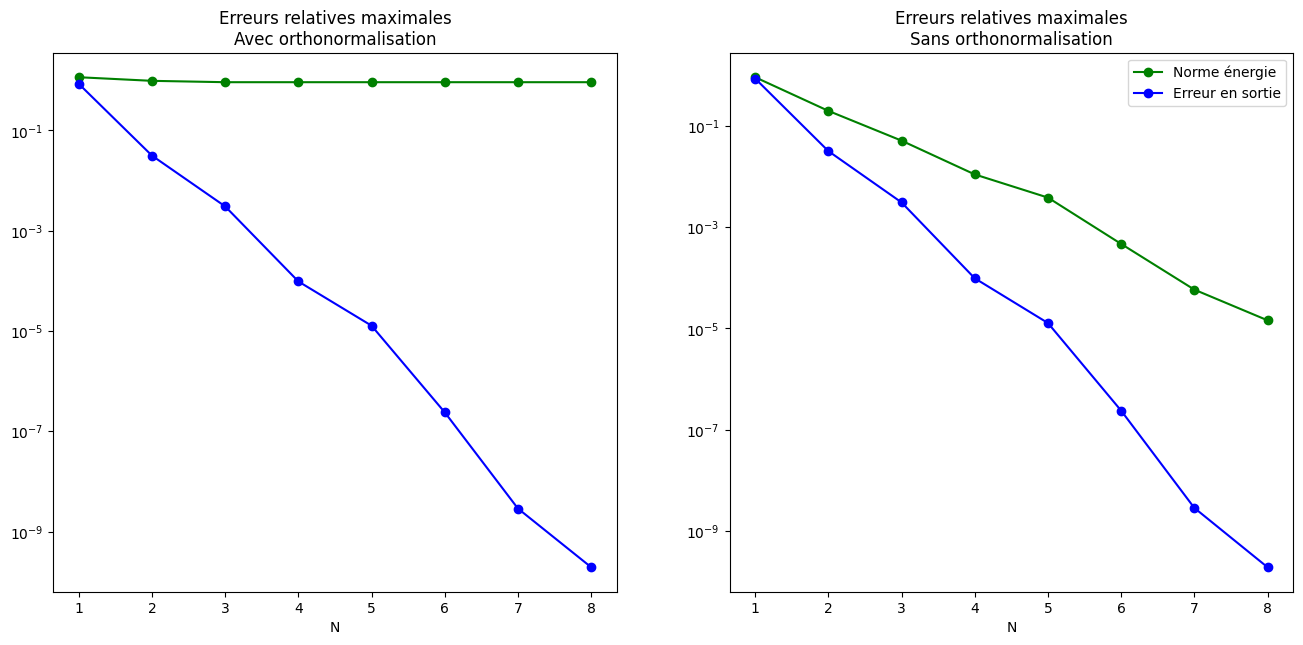

In [19]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 7))
ax[0].semilogy(N, nrgC, 'o-', color='g', label='Norme énergie')
ax[0].semilogy(N, outC, 'o-', color='b', label='Erreur en sortie')
ax[0].set_xlabel("N")
ax[0].set_title("Erreurs relatives maximales\nAvec orthonormalisation")
ax[1].semilogy(N, nrgC_, 'o-', color='g', label='Norme énergie')
ax[1].semilogy(N, outC_, 'o-', color='b', label='Erreur en sortie')
ax[1].set_xlabel("N")
ax[1].set_title("Erreurs relatives maximales\nSans orthonormalisation")
plt.legend()
plt.show()

Les figures ci-dessus montre l'évolution des erreurs relatives maximales en norme d'énergie et en sortie en fonction de $N$.  
* Avec orthonormalisation : L'erreur en sortie diminue comme prévu, alors que celle en norme énergie ne semble pas diminuer.
* Sans orhonormalisation : L'erreur en sortie diminue quadratiquement par rapport à celle en norme énergie, ce qui correspond à la théorie.

## 4. Comparaison du temps moyen du CPU.

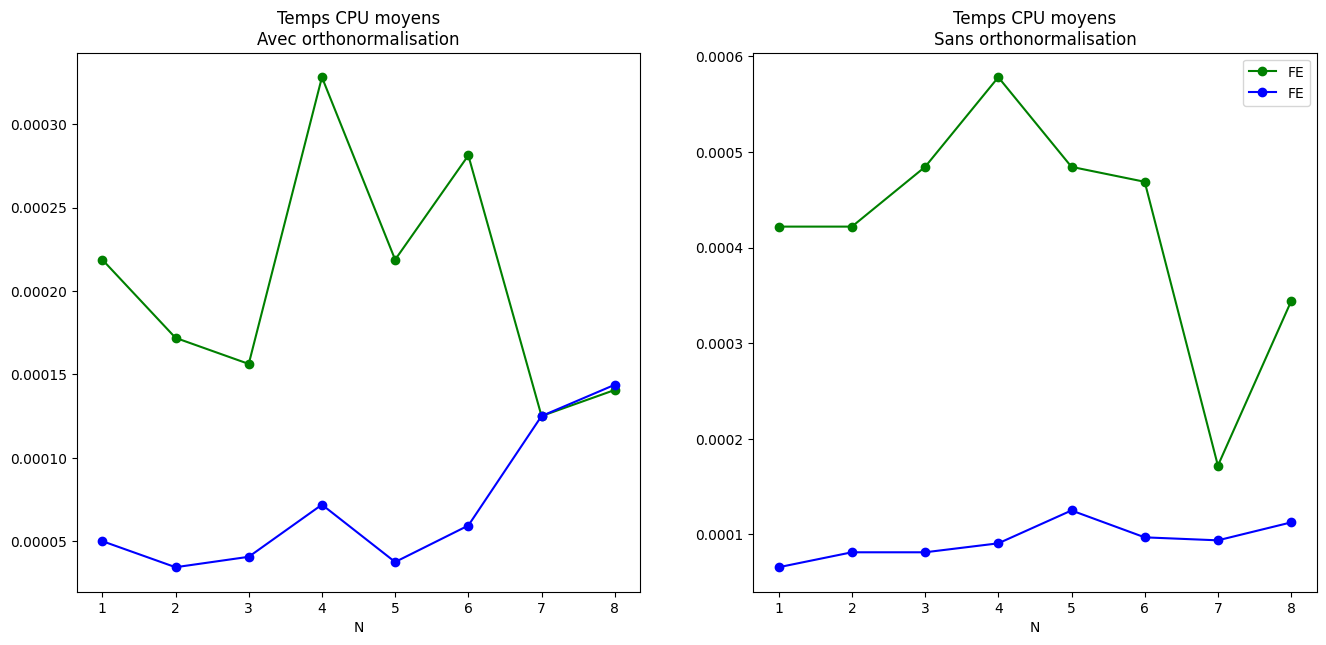

In [20]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 7))
ax[0].plot(N, FETimesC,'o-', color='g', label="FE")
ax[0].plot(N, RBTimesC,'o-', color='b', label="FE")
ax[0].set_xlabel("N")
ax[0].set_title("Temps CPU moyens\nAvec orthonormalisation")
ax[1].plot(N, FETimesC_,'o-', color='g', label="FE")
ax[1].plot(N, RBTimesC_,'o-', color='b', label="FE")
ax[1].set_xlabel("N")
ax[1].set_title("Temps CPU moyens\nSans orthonormalisation")
plt.legend()
plt.show()

D'après les figures ci-dessus, il ne semble pas y avoir de relation entre les temps de calcul et $N$.  
Toutefois, elles indiquent clairement à quel point l'étape en ligne de la base réduite est plus rapide que le calcul de la solution exacte par éléments finis.  
Les temps de calcul sont similaires avec ou sans orthonormalisation.

## 5. Erreur relative de 1 %

In [21]:
k = 0
while (outC[k] > 1e-2):
    k += 1

print("N =", k+1)
print("Précision :", 100*outC_[k], "%")

N = 3
Précision : 0.3056515255910851 %


Pour obtenir une précision relative de la sortie de $1\%$, $N$ doit être supérieur ou égal à $3$.

In [22]:
avgTime = FETimesC_[k] - RBTimesC_[k]
print('Gain moyen de temps CPU :', avgTime)

Gain moyen de temps CPU : 0.000403125


En moyenne, ce pourcentage correspond à un gain de temps CPU de $\sim 1.2$ ms

## 6. Autres finesses de maillage

En répétant les étapes 3. à 5. sur les triangulations moyennes et fines, nous obtenons les résultats suivants :

### Maillage moyen (`medium`)

In [23]:
N = np.arange(Nmax) + 1
Ahq, Fh = loadFEMat('medium')
AhqBar = assembleA(muBar, Ahq)
nIter = 7

nrgM, outM, FETimesM, RBTimesM = computeErrTime()
nrgM_, outM_, FETimesM_, RBTimesM_ = computeErrTime(ortho=False)

*Erreurs Relatives*

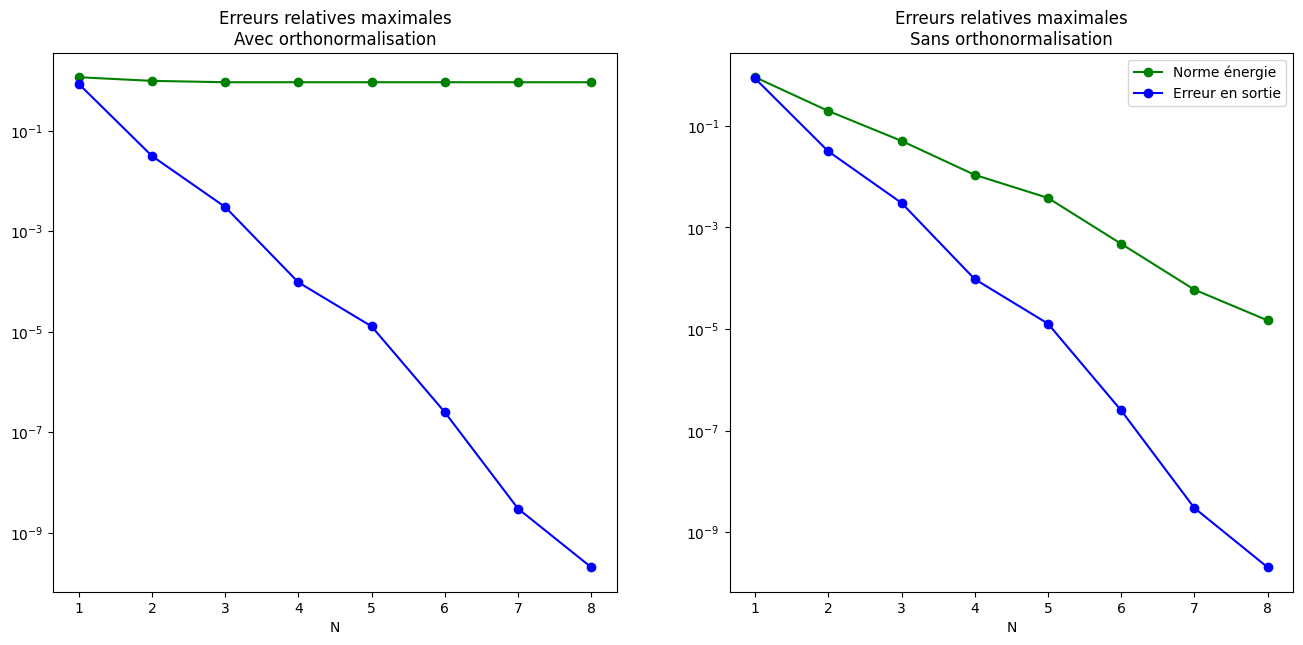

In [24]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 7))
ax[0].semilogy(N, nrgM, 'o-', color='g', label='Norme énergie')
ax[0].semilogy(N, outM, 'o-', color='b', label='Erreur en sortie')
ax[0].set_xlabel("N")
ax[0].set_title("Erreurs relatives maximales\nAvec orthonormalisation")
ax[1].semilogy(N, nrgM_, 'o-', color='g', label='Norme énergie')
ax[1].semilogy(N, outM_, 'o-', color='b', label='Erreur en sortie')
ax[1].set_xlabel("N")
ax[1].set_title("Erreurs relatives maximales\nSans orthonormalisation")
plt.legend()
plt.show()

*Temps CPU Moyens*

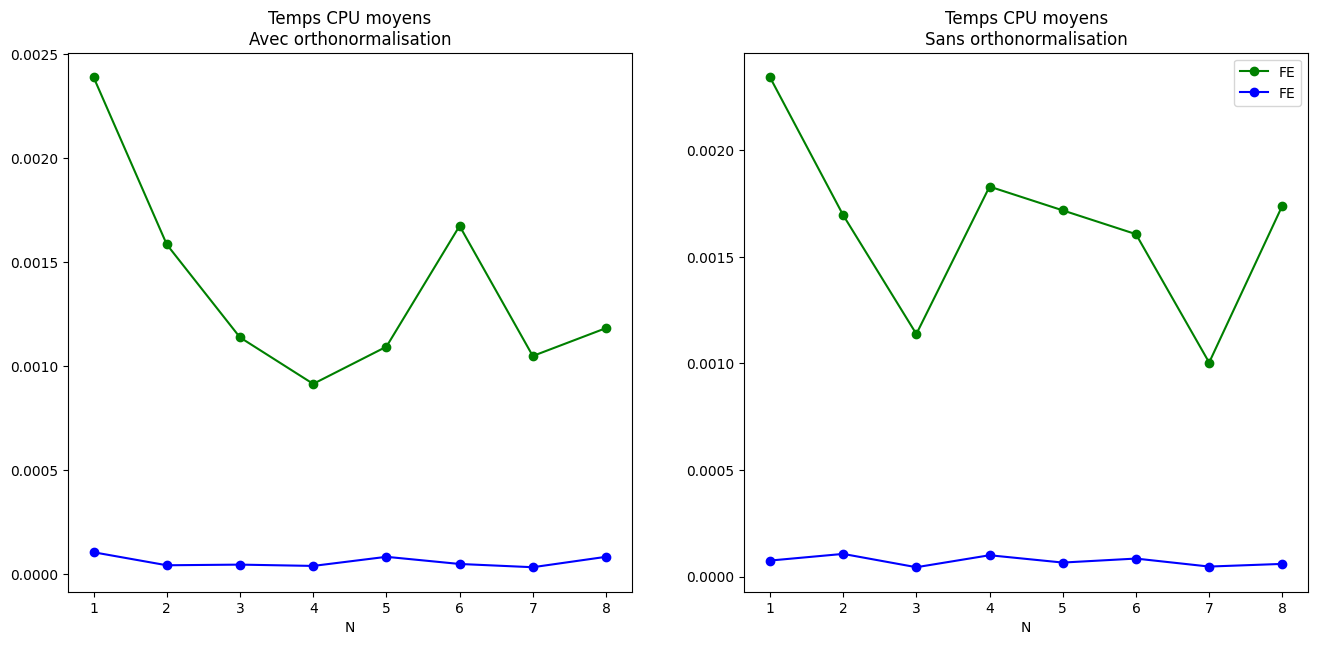

In [25]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 7))
ax[0].plot(N, FETimesM,'o-', color='g', label="FE")
ax[0].plot(N, RBTimesM,'o-', color='b', label="FE")
ax[0].set_xlabel("N")
ax[0].set_title("Temps CPU moyens\nAvec orthonormalisation")
ax[1].plot(N, FETimesM_,'o-', color='g', label="FE")
ax[1].plot(N, RBTimesM_,'o-', color='b', label="FE")
ax[1].set_xlabel("N")
ax[1].set_title("Temps CPU moyens\nSans orthonormalisation")
plt.legend()
plt.show()

*Erreur relative de 1%*

In [26]:
k = 0
while (outM[k] > 1e-2):
    k += 1

print("N =", k+1)
print("Précision :", 100*outM_[k], "%")

N = 3
Précision : 0.3022017037573677 %


Pour obtenir une erreur relative de la sortie de $1\%$, $N$ doit être supérieur ou égal à $3$.

In [27]:
avgTime = FETimesM_[k] - RBTimesM_[k]
print('Gain moyen de temps CPU :', avgTime)

Gain moyen de temps CPU : 0.0010946428571428572


En moyenne, ce pourcentage correspond à un gain de temps CPU de $\sim 5.4$ ms

### Maillage fin (`fine`)

In [28]:
N = np.arange(Nmax)+1
Ahq, Fh = loadFEMat('fine')
AhqBar = assembleA(muBar, Ahq)
nIter = 7

nrgF, outF, FETimesF, RBTimesF = computeErrTime()
nrgF_, outF_, FETimesF_, RBTimesF_ = computeErrTime(ortho=False)

*Erreurs Relatives*

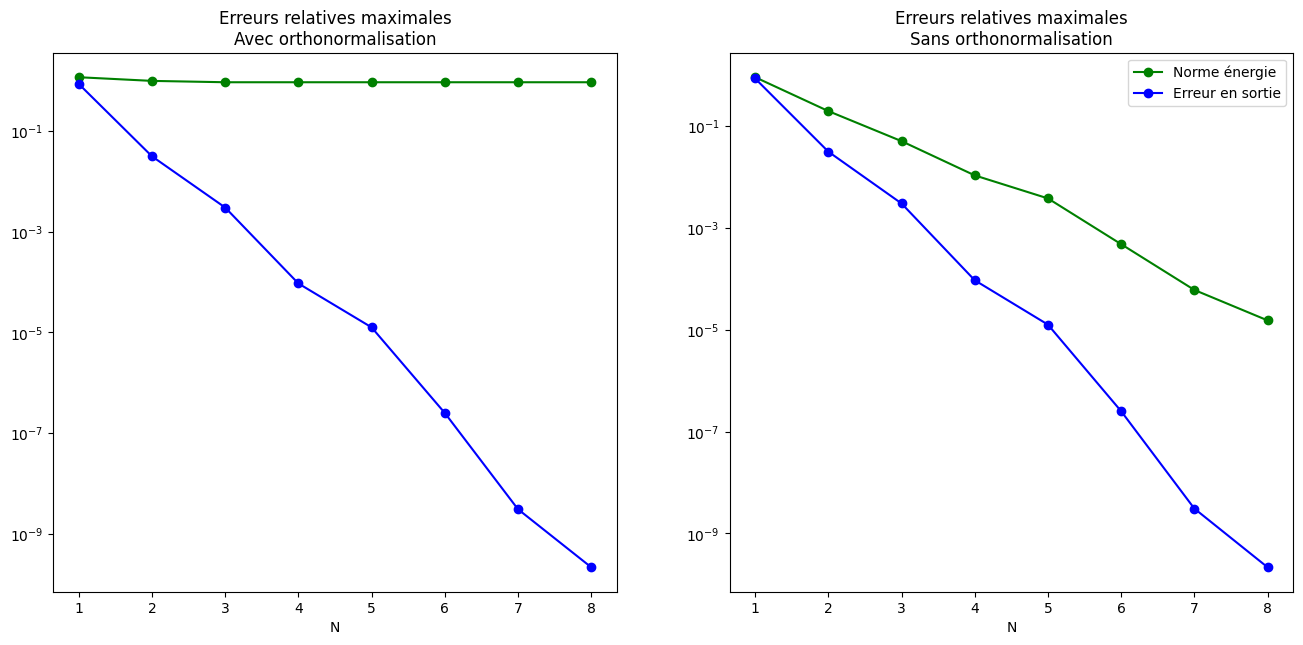

In [29]:
N = np.arange(Nmax) + 1

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 7))
ax[0].semilogy(N, nrgF, 'o-', color='g', label='Norme énergie')
ax[0].semilogy(N, outF, 'o-', color='b', label='Erreur en sortie')
ax[0].set_xlabel("N")
ax[0].set_title("Erreurs relatives maximales\nAvec orthonormalisation")
ax[1].semilogy(N, nrgF_, 'o-', color='g', label='Norme énergie')
ax[1].semilogy(N, outF_, 'o-', color='b', label='Erreur en sortie')
ax[1].set_xlabel("N")
ax[1].set_title("Erreurs relatives maximales\nSans orthonormalisation")
plt.legend()
plt.show()

*Temps CPU Moyens*

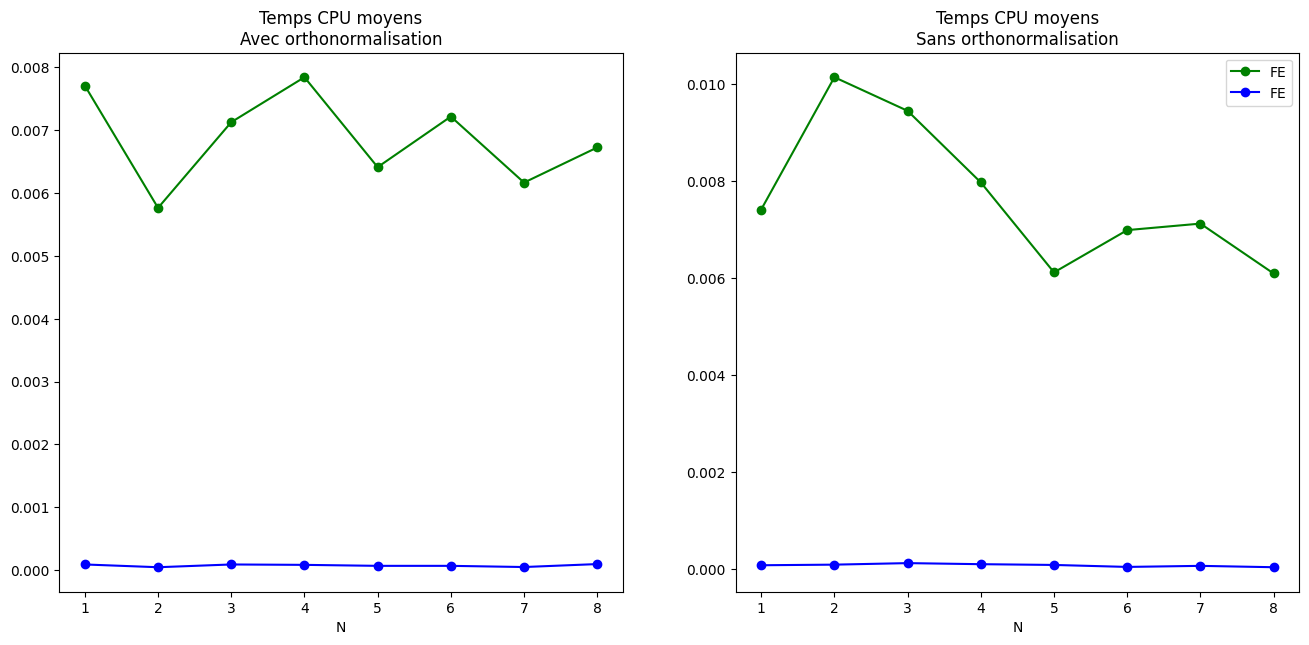

In [30]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 7))
ax[0].plot(N, FETimesF,'o-', color='g', label="FE")
ax[0].plot(N, RBTimesF,'o-', color='b', label="FE")
ax[0].set_xlabel("N")
ax[0].set_title("Temps CPU moyens\nAvec orthonormalisation")
ax[1].plot(N, FETimesF_,'o-', color='g', label="FE")
ax[1].plot(N, RBTimesF_,'o-', color='b', label="FE")
ax[1].set_xlabel("N")
ax[1].set_title("Temps CPU moyens\nSans orthonormalisation")
plt.legend()
plt.show()

*Erreur relative de 1%*

In [31]:
k = 0
while (outF[k] > 1e-2):
    k += 1

print("N =", k+1)
print("Précision :", 100*outF_[k], "%")

N = 3
Précision : 0.3000102133288653 %


Pour obtenir une erreur relative de la sortie de $1\%$, $N$ doit être supérieur ou égal à $3$.

In [32]:
avgTime = FETimesF_[k] - RBTimesF_[k]
print('Gain moyen de temps CPU :', avgTime)

Gain moyen de temps CPU : 0.009310714285714287


En moyenne, ce pourcentage correspond à un gain de temps CPU de $\sim 28$ ms

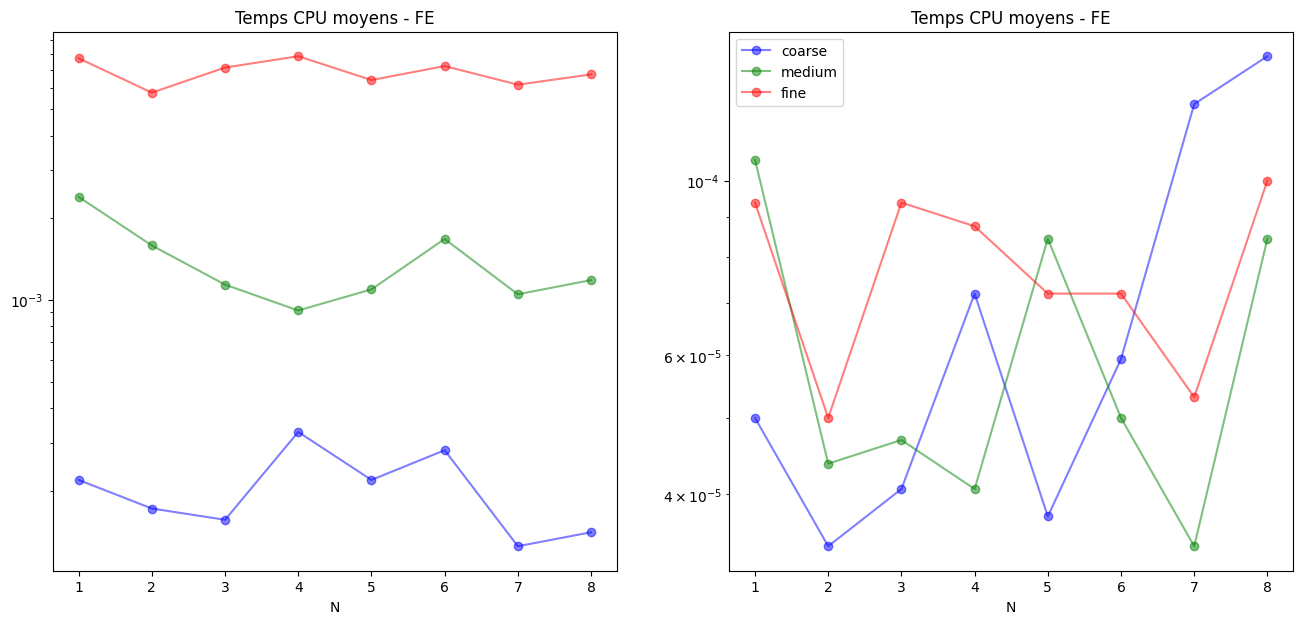

In [33]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 7))
ax[0].semilogy(N, FETimesC,'o-', color='b', label="coarse", alpha=0.5)
ax[0].semilogy(N, FETimesM,'o-', color='g', label="medium", alpha=0.5)
ax[0].semilogy(N, FETimesF,'o-', color='r', label="fine", alpha=0.5)
ax[0].set_xlabel("N")
ax[0].set_title("Temps CPU moyens - FE")
ax[1].semilogy(N, RBTimesC,'o-', color='b', label="coarse", alpha=0.5)
ax[1].semilogy(N, RBTimesM,'o-', color='g', label="medium", alpha=0.5)
ax[1].semilogy(N, RBTimesF,'o-', color='r', label="fine", alpha=0.5)
ax[1].set_xlabel("N")
ax[1].set_title("Temps CPU moyens - FE")
plt.legend()
plt.show()

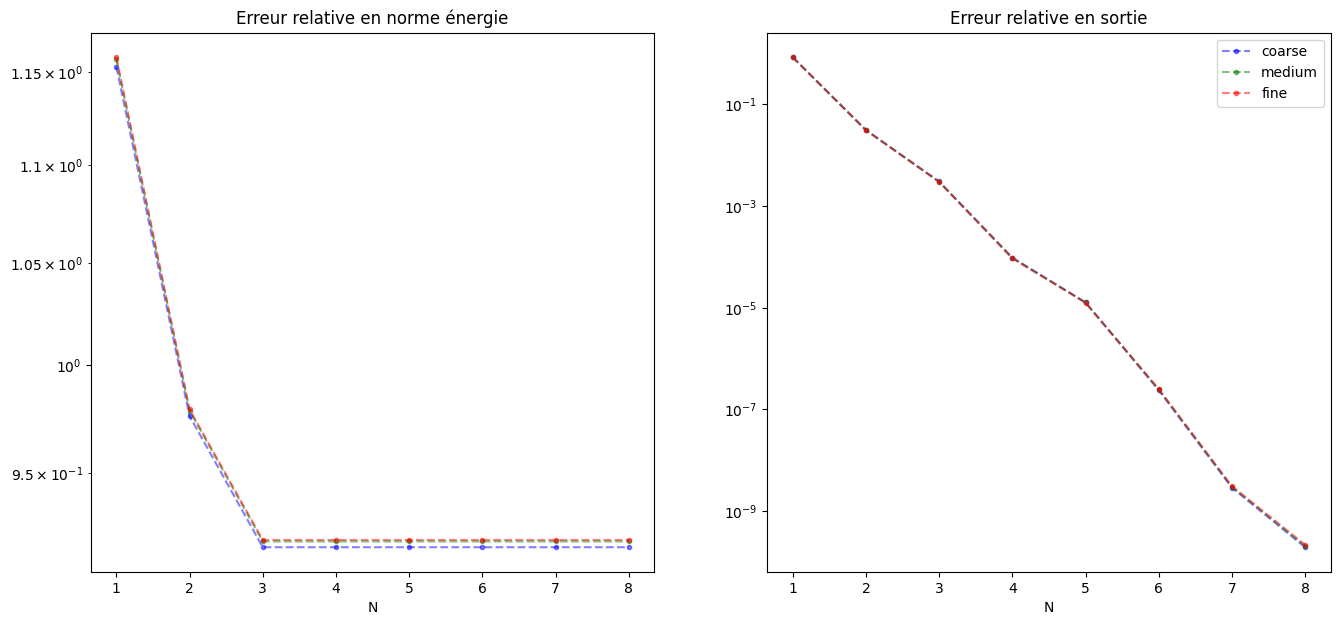

In [34]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 7))
ax[0].semilogy(N, nrgC,'.--', color='b', label="coarse", alpha=0.5)
ax[0].semilogy(N, nrgM,'.--', color='g', label="medium", alpha=0.5)
ax[0].semilogy(N, nrgF,'.--', color='r', label="fine", alpha=0.5)
ax[0].set_xlabel("N")
ax[0].set_title("Erreur relative en norme énergie")
ax[1].semilogy(N, outC,'.--', color='b', label="coarse", alpha=0.5)
ax[1].semilogy(N, outM,'.--', color='g', label="medium", alpha=0.5)
ax[1].semilogy(N, outF,'.--', color='r', label="fine", alpha=0.5)
ax[1].set_xlabel("N")
ax[1].set_title("Erreur relative en sortie")
plt.legend()
plt.show()

Sans surprise, le temps nécessaire pour calculer la solution directe FE augmente considérablement  alors que le temps nécessaire pour l'approximation RB est relativement constant autour de $0.4$ ms.  
Cette apparente indépendance par rapport à $\mathcal{N}$ est à nouveau observée sur les erreurs maximales et relatives de l'approximation RB.  

Nous remarquons que le $N$ minimal est toujours égal à $3$ pour obtenir une erreur relative de sortie de $1 \%$. 

---
En résumé, **plus la triangulation FE est fine, plus le besoin d'une approximation de base réduite est important**. C'est exactement ce à quoi on s'attendait.

---
**c**) *Nous considérons maintenant un autre problème à un paramètre (P = 1). Cette fois, nous supposons que les conductivités sont fixées à $\{k_1, k_2, k_3, k_4\} = \{0.4, 0.6, 0.8, 1.2\}$, et que seul le nombre de Biot, $\mathrm{Bi}$, est autorisé à varier de $0.01$ à $1$. L'ensemble d'échantillons $S_N$ pour $N_{max} = 11$ est donné dans le fichier de données `RB_sample.sample2`. Générer un Z orthonormé à partir de l'ensemble d'échantillons en utilisant la triangulation moyenne.*

In [35]:
Ahq, Fh = loadFEMat("medium")
AhqBar = assembleA(muBar, Ahq)
sample = loadSample("sample2")
Nmax = 11

In [36]:
Z = buildZ(sample, Ahq, Fh, 11, 2)
Z_ = orthonormalize(Z)
Anq, Fn, Ln = buildOff(Z_, Ahq, Fh)

In [37]:
µ0 = np.array([0.4, 0.6, 0.8, 1.2, 1, 0.15])
un = spsolve(assembleA(µ0, Anq), Fn)
output = Ln.T@un
print("Sortie sur Gamma_root :", output)

Sortie sur Gamma_root : 1.5156084809573855


* Pour $\mu_0 = 0.4,0.6,0.8,1.2,0.15$, c'est-à-dire $\mathrm{Bi} = 0.15$, la valeur de la sortie est bien 
$$\boxed{T_{root_N}(\mu_0) \simeq 1,51561.}$$

* Étude de convergence sur un échantillon test.

In [38]:
def computeMu(Bi):
    return np.array([0.4, 0.6, 0.8, 1.2, 1, Bi])

N = np.arange(Nmax) + 1
Ahq, Fh = loadFEMat('medium')
AhqBar = assembleA(muBar, Ahq)
testSample = np.linspace(0.01, 1, 100)
nIter = 1
cas = 2

nrg, out, _, _ = computeErrTime()


*Erreurs relatives*

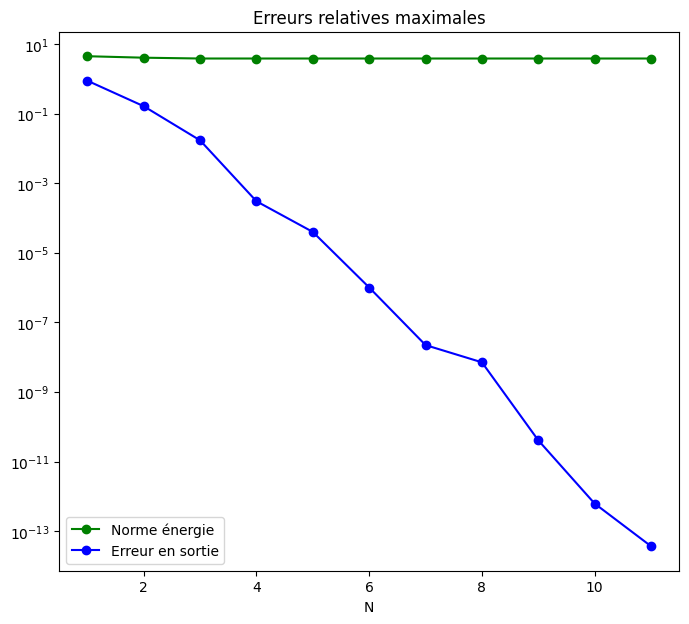

In [39]:
fig, ax = plt.subplots(figsize=(8, 7))
ax.semilogy(N, nrg, 'o-', color='g', label='Norme énergie')
ax.semilogy(N, out, 'o-', color='b', label='Erreur en sortie')
ax.set_xlabel("N")
ax.set_title("Erreurs relatives maximales")
plt.legend()
plt.show()

La figure ci-cessus montre les erreurs relatives maximales de la norme d'énergie et en sortie en fonction de $N$.  
Nous pouvons voir que l'erreur relative maximale de la norme d'énergie diminue peu tandis que celle en sortie diminue de manière significative lorsque $N$ devient plus grand.

* Minimisation de coût.

In [40]:
def cost(Bi):
    µ = np.array([0.4, 0.6, 0.8, 1.2, 1, Bi])
    un = spsolve(assembleA(µ, Anq), Fn)
    return Bi + Ln.T @ un


left = 0.01
right = 1.
costL = cost(left)
costR = cost(right)
k = 0

while (abs(costR-costL) > 1e-20 and k < 500):
    lTmp = left + (right-left) / 3
    rTmp = left + 2 * (right-left) / 3
    k += 1
    costL = cost(lTmp)
    costR = cost(rTmp)

    if costL < costR:
        right = rTmp
    elif costL > costR:
        left = lTmp
    else:
        left = lTmp
        right = rTmp


print("Nombre d'itérations :", k)
print("Nombre de Biot optimal :", (left+right) / 2)
print("Coût optimal :", cost((left+right) / 2))


Nombre d'itérations : 46
Nombre de Biot optimal : 0.40295266354775117
Coût optimal : 1.4655068704982928


En utilisant un algorithme de recherche par dichotomie avec une tolérance de $10^{-20}$, on trouve un coût optimal $C=1.4655$, obtenu pour un nombre de Biot $\mathrm{Bi} = 0.40295$.

---
**d**) *Enfin, nous considérons un problème à deux paramètres ($P = 2$) où les conductivités sont supposées être équivalentes, c'est-à-dire $k_1 = k_2 = k_3 = k_4$, mais peuvent varier entre $0.1$ et $10$ ; et le nombre de Biot, $\mathrm{Bi}$, peut varier entre $0.01$ et $1$. L'ensemble d'échantillons $S_N$ pour $N_{max} = 46$ est donné dans le fichier de données `RB_sample.sample3`. Générer un $Z$ orthonormal à partir de l'ensemble d'échantillons en utilisant la triangulation grossière.*

In [41]:
Ahq, Fh = loadFEMat("coarse")
AhqBar = assembleA(muBar, Ahq)
sample = loadSample("sample3")
Nmax = 46

In [42]:
Z = buildZ(sample, Ahq, Fh, 46, 3)
Z_ = orthonormalize(Z)
Anq, Fn, Ln = buildOff(Z_, Ahq, Fh)

In [43]:
def computeMu(kBi):
    k, Bi = kBi
    return np.array([k, k, k, k, 1, Bi])

N = np.arange(Nmax)+1
Ahq, Fh = loadFEMat('coarse')
AhqBar = assembleA(muBar, Ahq)
ntest = 400
ski = np.linspace(0.1, 10, 20)
sBi = np.linspace(0.01, 1, 20)

testSample = []
for k in ski:
    for Bi in sBi:
        testSample.append((k, Bi))
cas = 3

nrg, out, _, _ = computeErrTime()

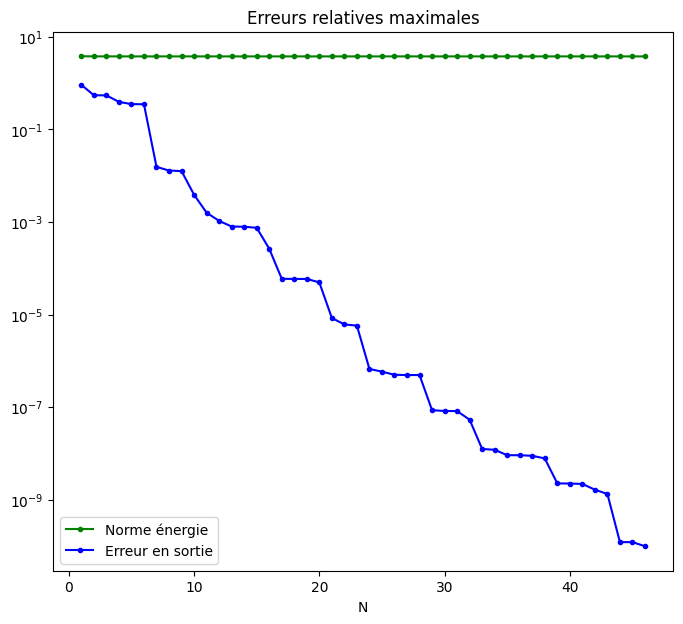

In [44]:
fig, ax = plt.subplots(figsize=(8, 7))
ax.semilogy(N, nrg, '.-', color='g', label='Norme énergie')
ax.semilogy(N, out, '.-', color='b', label='Erreur en sortie')
ax.set_xlabel("N")
ax.set_title("Erreurs relatives maximales")
plt.legend()
plt.show()

La figure ci-cessus montre les erreurs relatives maximales de la norme d'énergie et en sortie en fonction de $N$.  
Les résultats sont similaires à ceux des questions précédentes.